In [1]:
import math
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt

import keras
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
cwd = Path('/kaggle/input')
DATASET = cwd / Path('digit-recognizer')

In [3]:
train_df = pd.read_csv(str(DATASET) + '/train.csv')
test_df = pd.read_csv(str(DATASET) + '/test.csv')
test_df_answers = pd.read_csv(str(DATASET) + '/sample_submission.csv')

X_train, y_train = train_df.iloc[:, 1:], train_df.iloc[:, 0]
X_test = test_df

X_train = np.array(X_train).reshape(len(X_train), 28, 28, 1)
X_test = np.array(X_test).reshape(len(X_test), 28, 28, 1)

print("-"*10+"DATA-READ"+"-"*10)
print("X Train: {}\nX Test:  {}".format(X_train.shape, X_test.shape))

print("-"*29)
print("Max Val: {}\nMin Val: {}".format(X_train.max(), X_train.min()))

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("-"*10+"NORMALISED"+"-"*9)
print("Max Val: {}\nMin Val: {}".format(X_train.max(), X_train.min()))


y_train = keras.utils.to_categorical(y_train, num_classes=10)

----------DATA-READ----------
X Train: (42000, 28, 28, 1)
X Test:  (28000, 28, 28, 1)
-----------------------------
Max Val: 255
Min Val: 0
----------NORMALISED---------
Max Val: 1.0
Min Val: 0.0


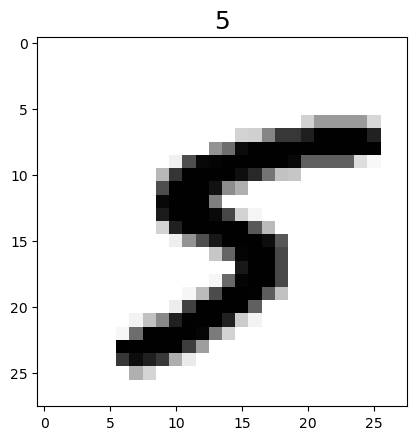

In [4]:
idx = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[idx], cmap='gray_r')
plt.title(np.argmax(y_train[idx]), fontsize=18)
plt.show();

In [5]:
def conv_layer():
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                            input_shape=input_shape),
        keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.BatchNormalization(axis=-1),
        keras.layers.Dropout(0.1),

        keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.BatchNormalization(axis=-1),
        keras.layers.Dropout(0.1),

        keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.BatchNormalization(axis=-1),
        keras.layers.Dropout(0.1),

        keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
        keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.BatchNormalization(axis=-1),
        keras.layers.Dropout(0.1),

        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(axis=-1),
        keras.layers.Dropout(0.25),        
        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(axis=-1),
        keras.layers.Dropout(0.5),
        
        keras.layers.Dense(10, activation='softmax'),        
    ])
    return model

In [6]:
input_shape = (28, 28, 1)
model = conv_layer()

In [7]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [8]:
def cosine_annealing(epoch, initial_lr, total_epochs):
    lr = 0.5 * initial_lr * (1 + math.cos(math.pi * epoch / total_epochs))
    return lr

In [9]:
epochs = 50
learning_rate = 0.001
reduce_lr = keras.callbacks.LearningRateScheduler(lambda epoch: cosine_annealing(epoch, learning_rate, epochs))
# early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, verbose=1)

In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                                       featurewise_std_normalization=True,
                                                       rotation_range=20,
                                                       width_shift_range=0.2,
                                                       height_shift_range=0.2,
                                                       shear_range=0.1,
                                                       zoom_range=0.2,
                                                       validation_split=0.2)

datagen.fit(X_train)

In [11]:
history = model.fit(datagen.flow(X_train, y_train, 
                                 batch_size=64, subset='training'),
                    validation_data=datagen.flow(X_train, y_train,
                                                 batch_size=8, subset='validation'),
                    epochs=epochs,
                    callbacks=[reduce_lr], verbose=1)

Epoch 1/50


2023-06-26 12:39:03.731439: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


525/525 [==============================] - 42s 53ms/step - loss: 0.6012 - accuracy: 0.8189 - val_loss: 1.0121 - val_accuracy: 0.7360 - lr: 0.0010
Epoch 2/50
525/525 [==============================] - 31s 60ms/step - loss: 0.1740 - accuracy: 0.9511 - val_loss: 0.1579 - val_accuracy: 0.9517 - lr: 9.9901e-04
Epoch 3/50
525/525 [==============================] - 31s 60ms/step - loss: 0.1269 - accuracy: 0.9628 - val_loss: 0.1127 - val_accuracy: 0.9674 - lr: 9.9606e-04
Epoch 4/50
525/525 [==============================] - 31s 59ms/step - loss: 0.1122 - accuracy: 0.9686 - val_loss: 0.0822 - val_accuracy: 0.9751 - lr: 9.9114e-04
Epoch 5/50
525/525 [==============================] - 31s 59ms/step - loss: 0.0985 - accuracy: 0.9720 - val_loss: 0.1021 - val_accuracy: 0.9719 - lr: 9.8429e-04
Epoch 6/50
525/525 [==============================] - 28s 52ms/step - loss: 0.0875 - accuracy: 0.9761 - val_loss: 0.0821 - val_accuracy: 0.9757 - lr: 9.7553e-04
Epoch 7/50
525/525 [=============================

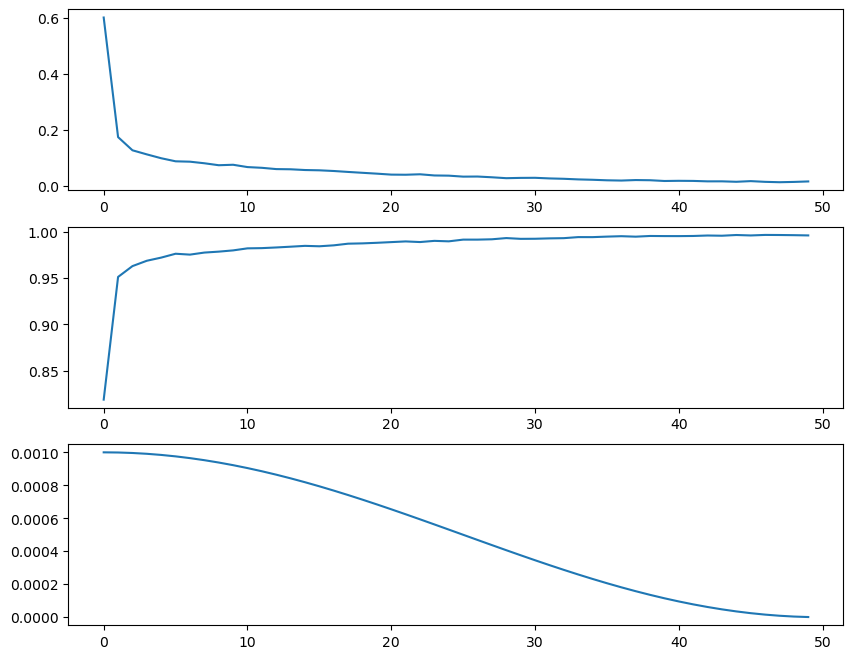

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

axes[0].plot(history.history['loss'])
axes[1].plot(history.history['accuracy'])
axes[2].plot(history.history['lr'])

plt.show();

In [13]:
result = model.predict(X_test, verbose=1)
result = result.argmax(axis=1)

875/875 [==============================] - 3s 3ms/step


In [14]:
ans = {
    'Label':[int(x) for x in result]
}
ans=pd.DataFrame(ans)

ImageId = {
    'ImageId': [i for i in range(1,28001)]
}
ImageId = pd.DataFrame(data=ImageId)

submission=pd.concat((ImageId, ans),axis=1)
submission.to_csv('submission.csv',index=False)